# project


In [30]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from pandas_datareader import data as pdr
import  yfinance as yf
import math
import json
from sklearn.preprocessing import StandardScaler
!pip install yfinance --upgrade --no-cache-dir


In [31]:
yf.pdr_override()
data_source = "yfinance"
data_name = "^TWII"
if data_source == "yfinance":
  df_train = pdr.get_data_yahoo(data_name, start="2019-01-01", end="2022-12-31").reset_index()
  df_test = pdr.get_data_yahoo(data_name, start="2023-01-01").reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [32]:
def epsilon_decay_cal(epsilon = 0.5, epsilon_min = 0.01, target_iterations = 100000) :
    epsilon = epsilon
    epsilon_min = epsilon_min
    target_iterations = target_iterations

    epsilon_decay = (epsilon_min / epsilon) ** (1 / target_iterations)
    print(f"需要 {target_iterations} 次迭代才會使 epsilon 降到 {epsilon_min}")

    return epsilon_decay

In [33]:
# MACD　function
def to_MACD(close, long = 26, short = 12, c = 9 ) :
    close_series = pd.Series(close)
    close_emaL = close_series.ewm(span=12, adjust=False).mean()
    close_emaS = close_series.ewm(span=26, adjust=False).mean()
    dif = close_emaL - close_emaS
    macd = dif.ewm(span=9, adjust=False).mean()
    MACD = dif - macd
    MACD_list = MACD.tolist()

    return MACD_list

In [34]:
class Agent:
    def __init__(self, state_size, window_size, trend, buy_trend, skip, batch_size, train_MACD, buy_MACD, MACD_enable):

        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.buy_trend = buy_trend
        self.skip = skip
        self.action_size =  11            ### action size
        self.action_size_half = self.action_size // 2  ###  -  1
        self.batch_size = batch_size
        self.memory = deque(maxlen=10000)
        self.inventory = []
        self.train_MACD = train_MACD
        self.buy_MACD = buy_MACD
        self.MACD_enable = MACD_enable
        self.returns_list = []

        self.gamma = 0.99
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        new_epsilon_decay = epsilon_decay_cal( epsilon = self.epsilon,
                             epsilon_min = self.epsilon_min,
                             target_iterations = len(self.trend) * 20)
        self.epsilon_decay = new_epsilon_decay

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        hidden1 = tf.layers.dense(self.X, 128, activation=tf.nn.relu)
        self.logits = tf.layers.dense(hidden1, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()

    ### model save and load
    def save_model(self, path):
        self.saver.save(self.sess, path)
        print(
            "Save current model"
          )

    def load_model(self, path):
        self.saver.restore(self.sess, path)
        print(
            "Load prev model"
          )

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict={self.X: state})[0]
        )
    def buy_act(self, state):
        return np.argmax(
            self.sess.run(self.logits, feed_dict={self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        if self.MACD_enable:
          block = (
              self.train_MACD[d : t + 1]
              if d >= 0
              else -d * [self.train_MACD[0]] + self.train_MACD[0 : t + 1]
          )
        else:
          block = (
              self.trend[d : t + 1]
              if d >= 0
              else -d * [self.trend[0]] + self.trend[0 : t + 1]
          )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_buy_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        if self.MACD_enable:
          block = (
              self.buy_MACD[d : t + 1]
              if d >= 0
              else -d * [self.buy_MACD[0]] + self.buy_MACD[0 : t + 1]
          )
        else:
          block = (
              self.buy_trend[d : t + 1]
              if d >= 0
              else -d * [self.buy_trend[0]] + self.buy_trend[0 : t + 1]
          )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict={self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict={self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict={self.X: X, self.Y: Y}
        )

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        # Simulate
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_buy_state(0)
        holding_inventory = 0


        for t in range(0, len(self.buy_trend) - 1, self.skip):
            action = self.buy_act(state)
            next_state = self.get_buy_state(t + 1)

            ### Action == do nothing
            if (
                action == 0
                and holding_inventory > holding_inventory // 10
                and self.buy_trend[t] > np.mean(inventory) + 100
            ):
              act = 1 + len(inventory) // 10
              for i in range(act):
                bought_price = inventory.pop(0)
                initial_money += self.buy_trend[t]
                states_sell.append(t)
              holding_inventory -= act
              try:
                invest = ((buy_close[t] - bought_price) / bought_price) * 100
              except:
                invest = 0
              print(
                "day %d, sell %d unit at price %f, investment %f %%, total balance %f,"
                % (t ,act  ,buy_close[t], invest, initial_money)
              )
            ### Action == Buy
            elif (
                action != 0
                and action <= (self.action_size_half)
                and initial_money >= action * self.buy_trend[t]
                and t < (len(self.buy_trend) - self.half_window)
            ):
              for i in range(action):
                inventory.append(self.buy_trend[t])
                states_buy.append(t)
                initial_money -= self.buy_trend[t]
              holding_inventory += action

              print(
                "day %d: buy %d unit at price %f, total balance %f"
                % (t ,action ,self.buy_trend[t], initial_money)
              )
            ### Action == Sell
            elif (
                action != self.action_size - 1
                and action > ( self.action_size_half )
                and holding_inventory >= ( action - self.action_size_half )
            ):
              act = action - self.action_size_half # 賣出數量
              for i in range(act):
                bought_price = inventory.pop(0)
                initial_money += self.buy_trend[t]
                states_sell.append(t)
              holding_inventory -= act
              try:
                invest = ((buy_close[t] - bought_price) / bought_price) * 100
              except:
                invest = 0

              print(
                "day %d, sell %d unit at price %f, investment %f %%, total balance %f,"
                % (t ,act ,buy_close[t], invest, initial_money)
              )

            state = next_state
        total_gains = initial_money - starting_money + len(inventory) * self.buy_trend[t]
        invest = ( total_gains  / starting_money) * 100
        return states_buy, states_sell, total_gains, invest


    def train(self, iterations, checkpoint, initial_money):
        loss = []
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            holding_inventory = 0
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                ### Action == Punish
                if (
                    action == 0
                ):
                  starting_money -= 0
                ### Action == Buy
                elif (
                    action != 0
                    and action <= (self.action_size_half)
                    and starting_money >= action * self.trend[t]
                    and t < (len(self.trend) - self.half_window)
                ):
                    for j in range(action):
                      inventory.append(self.trend[t])
                    holding_inventory += action
                    starting_money -= action * self.trend[t]
                ### Action == Sell
                elif (
                    action != self.action_size - 1
                    and action > ( self.action_size_half )
                    and holding_inventory >= ( action - self.action_size_half )
                ):
                    act = action - self.action_size_half # 賣出數量
                    for j in range(act):
                      bought_price = inventory.pop(0)
                      starting_money += self.trend[t]
                    holding_inventory -= act

                invest = (starting_money - initial_money) / initial_money
                self.memory.append(
                    (state, action, invest, next_state, starting_money < initial_money)
                )
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            loss.append(cost)
            total_profit = starting_money - initial_money + len(inventory) * self.trend[t]

            if (i + 1) % checkpoint == 0:
                print(
                    "epoch: %d, total rewards: %f, cost: %f, total money: %f"
                    % (i + 1, total_profit, cost, starting_money + len(inventory) * self.trend[t])
                )
        ### Plot loss
        plt.figure(figsize=(9, 5))
        plt.plot(np.squeeze(loss))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.savefig('loss_rate.png')
        plt.show()



/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
<ipython-input-27-43bf49f2303d>:32: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1 = tf.layers.dense(self.X, 128, activation=tf.nn.relu)
<ipython-input-27-43bf49f2303d>:33: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(hidden1, self.action_size)


需要 19500 次迭代才會使 epsilon 降到 0.01
epoch: 10, total rewards: 149655.456055, cost: 0.420675, total money: 1149655.456055
epoch: 20, total rewards: 327141.277344, cost: 0.086199, total money: 1327141.277344
epoch: 30, total rewards: 46674.363281, cost: 0.013783, total money: 1046674.363281
epoch: 40, total rewards: 94391.657227, cost: 0.088668, total money: 1094391.657227
epoch: 50, total rewards: 89811.708008, cost: 0.004674, total money: 1089811.708008
epoch: 60, total rewards: 205618.097656, cost: 0.006569, total money: 1205618.097656
epoch: 70, total rewards: 150370.850586, cost: 0.005970, total money: 1150370.850586
epoch: 80, total rewards: 170831.934570, cost: 0.010468, total money: 1170831.934570
epoch: 90, total rewards: 87908.498047, cost: 0.005399, total money: 1087908.498047
epoch: 100, total rewards: 85343.675781, cost: 0.019399, total money: 1085343.675781
epoch: 110, total rewards: 185576.372070, cost: 0.012929, total money: 1185576.372070
epoch: 120, total rewards: 129834.18

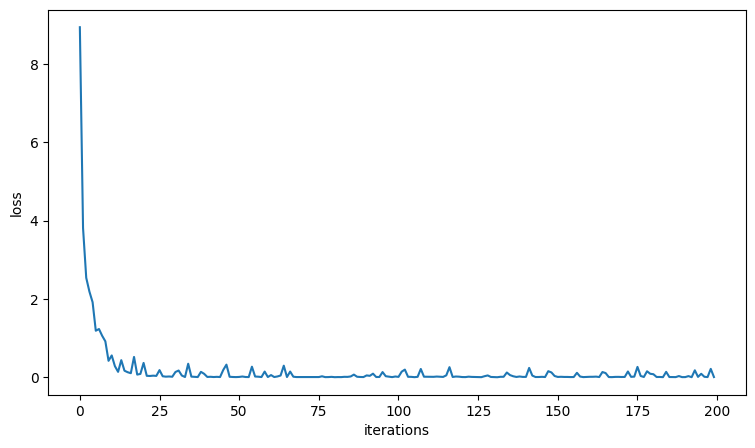

In [28]:
### Initialize

train_close = df_train.Close.values.tolist()
buy_close = df_test.Close.values.tolist()
train_MACD = to_MACD(list(train_close))
buy_MACD = to_MACD(list(buy_close))

initial_money = 1000000
window_size = 30
skip = 1
batch_size = 32

agent = Agent(
    state_size = window_size,
    window_size = window_size,
    trend = train_close,
    buy_trend = buy_close,
    skip = skip,
    batch_size = batch_size,
    train_MACD = train_MACD,
    buy_MACD = buy_MACD,
    MACD_enable = 1    #  change MACD_enable to 1 if you want to use MACD
)

### Train
agent.train(iterations=200, checkpoint=10, initial_money=initial_money)


day 0: buy 2 unit at price 14224.120117, total balance 971551.759766
day 1: buy 2 unit at price 14199.129883, total balance 943153.500000
day 2: buy 4 unit at price 14301.049805, total balance 885949.300781
day 3: buy 2 unit at price 14373.339844, total balance 857202.621094
day 4: buy 2 unit at price 14752.209961, total balance 827698.201172
day 5: buy 4 unit at price 14802.959961, total balance 768486.361328
day 6, sell 4 unit at price 14751.440430, investment 3.889749 %, total balance 827492.123047,
day 7: buy 2 unit at price 14731.639648, total balance 798028.843750
day 9, sell 3 unit at price 14927.009766, investment 4.377021 %, total balance 842809.873047,
day 10, sell 1 unit at price 14932.929688, investment 4.418416 %, total balance 857742.802734,
day 11, sell 1 unit at price 15493.820312, investment 7.795547 %, total balance 873236.623047,
day 12, sell 4 unit at price 15265.200195, investment 3.122620 %, total balance 934297.423828,
day 13: buy 2 unit at price 15420.129883, to

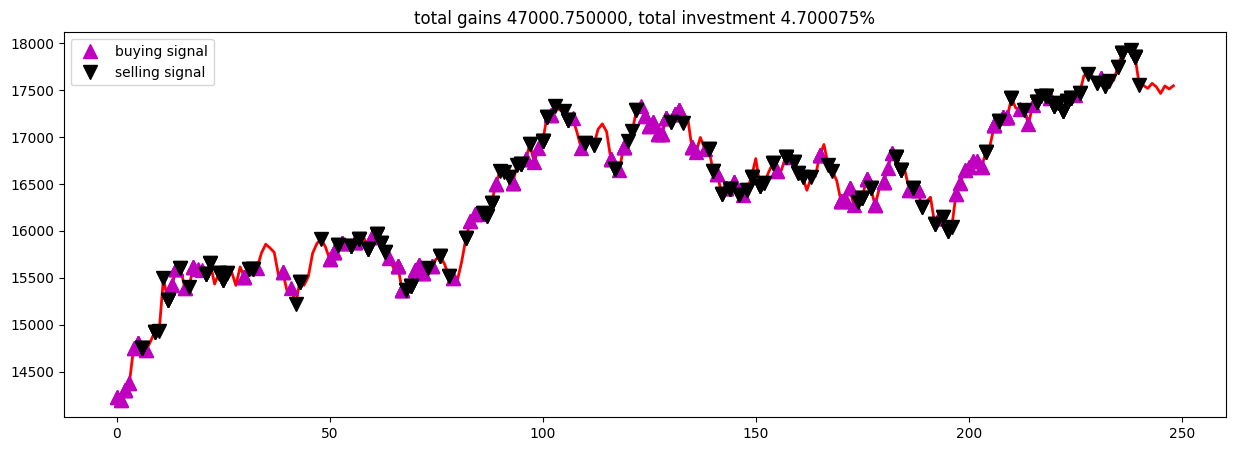

In [29]:
### Simulation
states_buy, states_sell, total_gains, invest = agent.buy(initial_money=initial_money)


### Plot
fig = plt.figure(figsize=(15, 5))
plt.plot(buy_close, color='r', lw=2.)
plt.plot(buy_close, '^', markersize=10, color='m', label='buying signal', markevery=states_buy)
plt.plot(buy_close, 'v', markersize=10, color='k', label='selling signal', markevery=states_sell)
plt.title('total gains %f, total investment %f%%' % (total_gains, invest))
plt.legend()
plt.savefig('Simulation.png')  # Save the plot as an image
plt.show()


